# Competitor Analysis

Compare: 
* Random Search
* SMAC
* BOHB
* HB
* Smashy 

In [68]:
library(data.table)
library(ggplot2)
library(ggpubr)
library(xtable)

source("../publication_themes.R")

theme_set(theme_Publication())

scale_colour_discrete = scale_colour_Publication()
scale_fill_discrete = scale_fill_Publication()

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [2]:
instances = readRDS("../../../paper_2021_multi_fidelity_surrogates/inst/instances.rds")

## LCBench

### Preparation

In [3]:
prob = "lcbench"

In [63]:
instances_lcbench = instances[cfg == prob, ]
test_instances = instances_lcbench[test == TRUE, ]$level
train_instances = instances_lcbench[test == FALSE, ]$level
all = c(train_instances, test_instances)

types = list(all = all, test = test_instances, train = train_instances)

In [5]:
df_s = readRDS(file.path("..", "results_sequential", "prepared_files_for_analysis", prob, "result_sequential.rds"))
df_p = readRDS(file.path("..", "results_sequential", "prepared_files_for_analysis", prob, "result_parallel.rds"))

In [6]:
df_s$algorithm = as.factor(df_s$algorithm)
levels(df_s$algorithm) = c("BOHB", "HB", "RS", "SMAC", "OURS")

In [18]:
# Mean normalized regret (per task)
df_s_a = df_s[, .(mean_nr = mean(normalized_regret), sd_nr = sd(normalized_regret), n = .N), by = c("algorithm", "problem", "task", "budget_cum")]
# Mean normalized regress (across all tasks)
df_s_t_all = df_s_a[, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]
# Mean normalized regress (across all train tasks)
df_s_t_train = df_s_a[task %in% train_instances, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]
# Mean normalized regress (across all test tasks)
df_s_t_test = df_s_a[task %in% test_instances, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]

df_s_t = list(all = df_s_t_all, train = df_s_t_train, test = df_s_t_test)

### Analysis: Learning Curves 

In [36]:
axis = "standard"
axis = "log"

for (type in c("all", "train", "test")) {
    p = ggplot(data = df_s_t[[type]]) + geom_line(aes(x = budget_cum / 52, y = mean_nr_across_tasks, colour = algorithm)) 
    p = p + scale_colour_Publication()
    if (axis == "log")
        p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
    p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
    p = p + ggtitle(paste0("LCbench (", type, " tasks)"))
    p # + geom_vline(xintercept = 4.6)
    ggsave(paste0("../results_sequential/figures/lcbench_new/", "lc_averaged_", type, "_", axis, ".png"), p, width = 5, height = 4)
}

In [33]:
axis = "standard"
# axis = "log"

dir.create(paste0("../results_sequential/figures/lcbench_new/tasks/", axis), showWarnings = FALSE, recursive = TRUE)

for (tt in unique(df_s$task)) {
    
    p = ggplot(data = df_s_a[task == tt, ]) 
    p = p + geom_ribbon(aes(x = budget_cum / 52, ymin = mean_nr - sd_nr, ymax = mean_nr + sd_nr, fill = algorithm), alpha = 0.3)
    p = p + geom_line(aes(x = budget_cum / 52, y = mean_nr, colour = algorithm)) 
    p = p + scale_colour_Publication() + scale_fill_Publication()
    if (axis == "log")
        p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
    p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
    p = p + ggtitle(paste0("LCbench (task: ", tt, ")"))
   
    ggsave(file.path("../results_sequential/figures/lcbench_new/tasks/", axis, paste0(tt, ".png")), p, width = 5, height = 4)
}

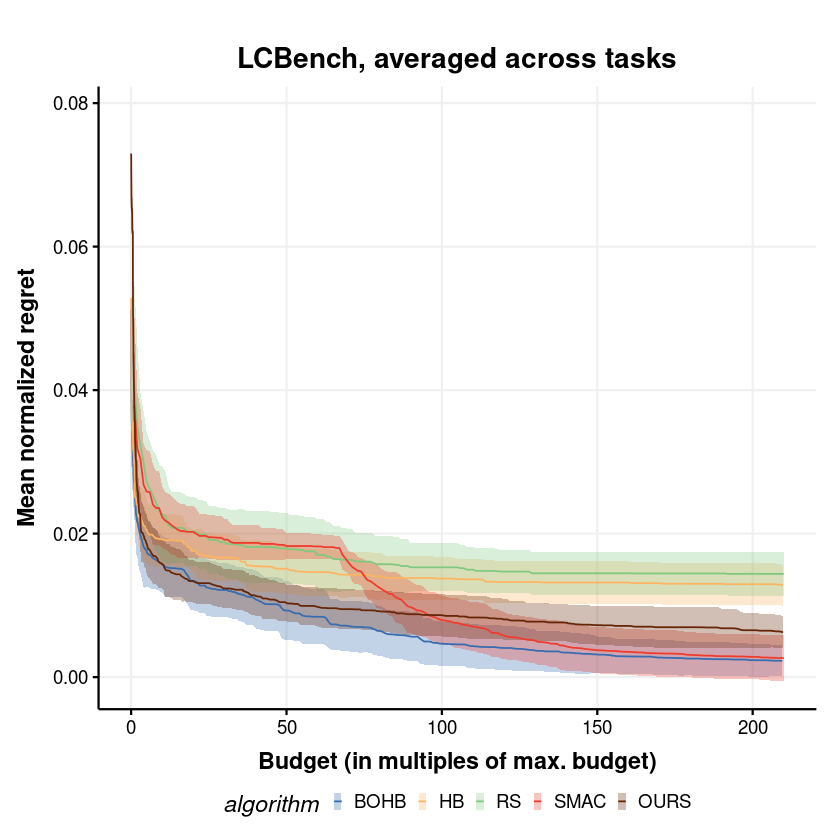

In [78]:
p

### Analysis: Rank Analysis (Test Instances) 

In [ ]:
# Create a Rank Plot 
rank_table = lapply(c(seq(1, 250)), function(bmax) {
    df_s_r = df_s[, .SD[budget_cum <= 52 * bmax & task %in% test_instances]]
    df_s_r = df_s_r[, .SD[which.min(performance)], by = c("task", "job.id", "algorithm")]
    df_s_r = df_s_r[, repl := 1:.N, by = c("task", "algorithm")]
    df_s_r[, rank := rank(performance), by = c("repl", "task")]
    df_s_r = df_s_r[, .(mean_rank_across_repls = mean(rank)), by = c("task", "algorithm")]
    df_s_r = df_s_r[, .(mean_rank = round(mean(mean_rank_across_repls), 2)), by = c("algorithm")]
    df_s_r$bmax = 52 * bmax
    df_s_r
})
rank_table = do.call(rbind, rank_table)

In [67]:
for (type in c("all", "train", "test")) {
    rank_table = lapply(c(1, 10, 100), function(bmax) {
        df_s_r = df_s[task %in% types[[type]], .SD[budget_cum <= 52 * bmax]]
        df_s_r = df_s_r[, .SD[which.min(performance)], by = c("task", "job.id", "algorithm")]
        df_s_r = df_s_r[, repl := 1:.N, by = c("task", "algorithm")]
        df_s_r[, rank := rank(performance), by = c("repl", "task")]
        df_s_r = df_s_r[, .(mean_rank_across_repls = mean(rank)), by = c("task", "algorithm")]
        df_s_r = df_s_r[, .(mean_rank = round(mean(mean_rank_across_repls), 2)), by = c("algorithm")]
        df_s_r$bmax = 52 * bmax
        df_s_r
    })
    rank_table = do.call(rbind, rank_table)
    rank_table = reshape2::recast(data = rank_table, measure.var = "mean_rank", id.var = c("algorithm", "bmax"), formula = algorithm ~ bmax)
    rank_table
    print(xtable(rank_table, type = "latex"), file = paste0("../results_sequential/figures/lcbench_new/ranks_", type, ".tex"))
}

## NB301

### Preparation

In [69]:
prob = "nb301"

instances_lcbench = instances[cfg == prob, ]
test_instances = instances_lcbench[test == TRUE, ]$level
train_instances = instances_lcbench[test == FALSE, ]$level
all = c(train_instances, test_instances)

types = list(all = all, test = test_instances, train = train_instances)

df_s = readRDS(file.path("..", "results_sequential", "prepared_files_for_analysis", prob, "result_sequential.rds"))

df_s$algorithm = as.factor(df_s$algorithm)
levels(df_s$algorithm) = c("BOHB", "HB", "RS", "SMAC")

# Mean normalized regret (per task)
df_s_a = df_s[, .(mean_nr = mean(normalized_regret), sd_nr = sd(normalized_regret), n = .N), by = c("algorithm", "problem", "task", "budget_cum")]
# Mean normalized regress (across all tasks)
df_s_t_all = df_s_a[, .(mean_nr_across_tasks = mean(mean_nr)), by = c("algorithm", "problem", "budget_cum")]


### Analysis: Learning Curves 

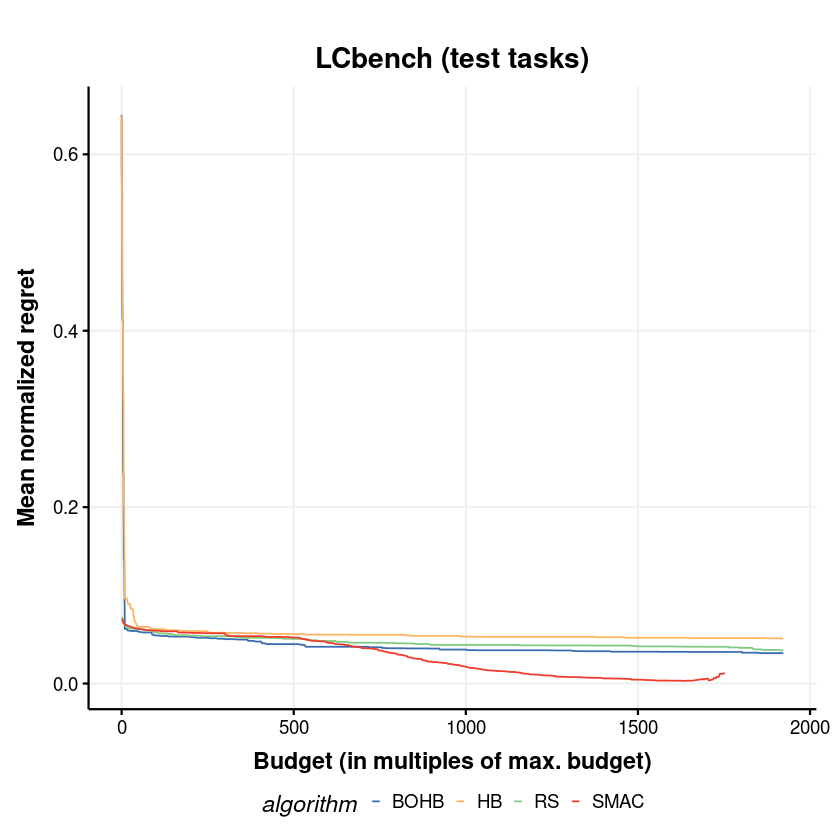

In [72]:
axis = "standard"
# axis = "log"

p = ggplot(data = df_s_t_all) + geom_line(aes(x = budget_cum / 52, y = mean_nr_across_tasks, colour = algorithm)) 
p = p + scale_colour_Publication()
if (axis == "log")
    p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
p = p + ggtitle(paste0("LCbench (", type, " tasks)"))
p # + geom_vline(xintercept = 4.6)
ggsave(paste0("../results_sequential/figures/nb301/", "lc_averaged_", type, "_", axis, ".png"), p, width = 5, height = 4)

In [79]:
axis = "standard"
axis = "log"

p = ggplot(data = df_s_a) 
p = p + geom_ribbon(aes(x = budget_cum / 52, ymin = mean_nr - sd_nr, ymax = mean_nr + sd_nr, fill = algorithm), alpha = 0.3)
p = p + geom_line(aes(x = budget_cum / 52, y = mean_nr, colour = algorithm)) 
p = p + scale_colour_Publication() + scale_fill_Publication()
if (axis == "log")
    p = p + scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x), labels = trans_format("log10", math_format(10^.x)))
p = p + xlab("Budget (in multiples of max. budget)") + ylab("Mean normalized regret")
p = p + ggtitle(paste0("nb301"))

ggsave(file.path("../results_sequential/figures/nb301/", paste0(axis, "_with_cb.png")), p, width = 5, height = 4)


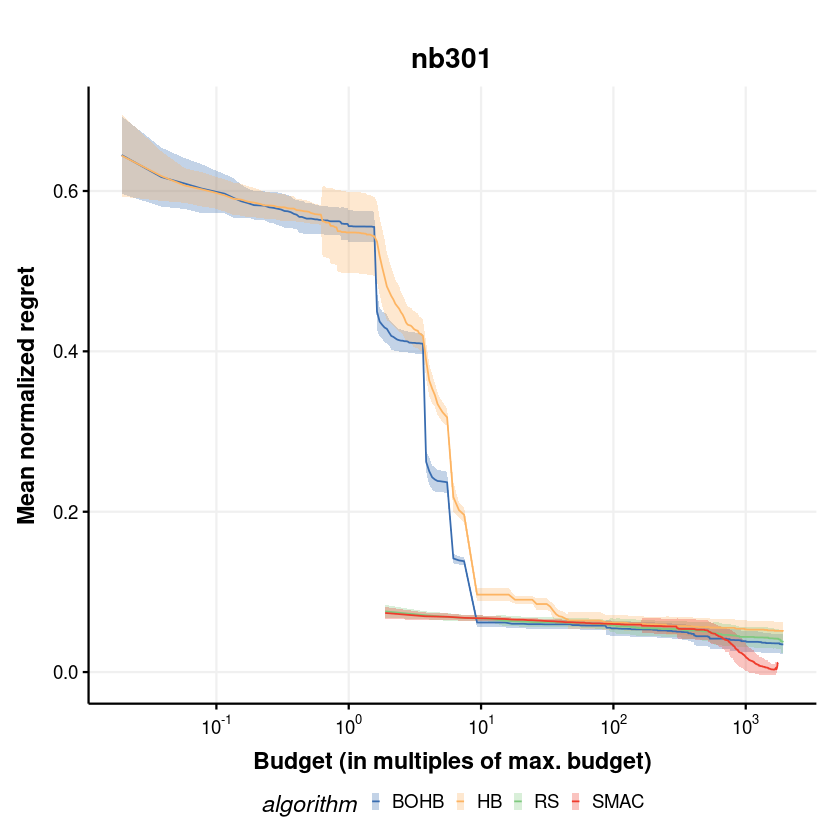

In [80]:
p